# Standard Imports

In [1]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, ConcatDataset, Subset
from collections import Counter
from torchvision import transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, balanced_accuracy_score, f1_score, roc_curve 

# Custom Imports

In [2]:
custom_modules_path = os.path.abspath(r'F:\Capstone\DFCA')

# Add the path to sys.path
if custom_modules_path not in sys.path:
    sys.path.append(custom_modules_path)

from utils.datasets import SpectrogramDataset
from utils.augmentations import ZScoreNormalizeSpectrogram,AugmentSpectrogram
from utils.metrics_utils import calculate_pAUC, plot_confusion_matrix
from models.feature_extractor import CQTFeatureExtractor
from models.heads import AnomalyScorer
from utils.metrics_utils import calculate_pAUC, plot_confusion_matrix

f:\CapStone\DFCA\capstone\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# CQT Classifier

In [3]:
class CQTMobileViTClassifier(nn.Module):
    """
    A complete classifier that combines the CQTFeatureExtractor (backbone)
    with any given classification head.
    """
    def __init__(self, head):
        super().__init__()
        self.backbone = CQTFeatureExtractor()

        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.head = head

    def forward(self, x):
        # Data flow: input -> backbone -> pool -> flatten -> head -> output
        features = self.backbone(x)
        pooled_features = self.pool(features)
        flattened_features = torch.flatten(pooled_features, 1)
        logits = self.head(flattened_features)
        return logits

# Device Configfuration's

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}" + (f" - {torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else ""))

FEATURES_DIR = os.path.abspath(r'F:\CapStone\DFCA\data\features\-6_dB_features')
CHECKPOINT_DIR = os.path.abspath(r'F:\Capstone\DFCA\checkpoints\CQT_MobileViT')
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
print(f"Checkpoints will be saved to: {CHECKPOINT_DIR}")


BATCH_SIZE = 32
NUM_EPOCHS = 50
LR = 5e-5
WEIGHT_DECAY = 1e-2
PATIENCE=5

print(f"Learning Rate: {LR} | Weight decay: {WEIGHT_DECAY}")

Using Device: cuda - NVIDIA GeForce MX450
Checkpoints will be saved to: F:\Capstone\DFCA\checkpoints\CQT_MobileViT
Learning Rate: 5e-05 | Weight decay: 0.01


# Evaluate and Training Loops

In [5]:
def _compute_primary_probs_and_loss_from_head(outputs, labels, criterion):
    """
    Computes probabilities, predictions, and loss for a binary classifier head.
    """
    logits = outputs.squeeze()
    probs = torch.sigmoid(logits)
    loss = criterion(logits, labels.float())
    preds = (probs > 0.5).long()
    return probs, preds, loss

def evaluate_model(model, data_loader, criterion, phase="Evaluation", device=device, threshold=0.5):
    model.eval()
    running_loss = 0.0
    all_labels, all_probs = [], []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc=phase):
            # 1. Load data to the specified device
            specs = batch['spectrogram'].to(device)
            labels = batch['label'].to(device).long()

            outputs = model(specs)

            probs, _, loss = _compute_primary_probs_and_loss_from_head(outputs, labels, criterion)

            running_loss += loss.item() * specs.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.detach().cpu().numpy())

    # --- Metrics Calculation ---
    avg_loss = running_loss / len(data_loader.dataset)
    
    # During validation, find the best F1-score and its threshold
    best_threshold = threshold
    if phase == "Validation":
        best_f1 = 0
        for thresh in np.arange(0.01, 1.0, 0.01):
            preds_at_thresh = (np.array(all_probs) > thresh).astype(int)
            f1_candidate = f1_score(all_labels, preds_at_thresh)
            if f1_candidate > best_f1:
                best_f1 = f1_candidate
                best_threshold = thresh
        print(f"Optimal Threshold found: {best_threshold:.2f} (Best F1-score: {best_f1:.4f})")

    # Use the best threshold for final predictions
    all_preds = (np.array(all_probs) > best_threshold).astype(int)
    
    # Calculate all metrics
    auc_score = roc_auc_score(all_labels, all_probs) if len(np.unique(all_labels)) > 1 else float('nan')
    acc_score = accuracy_score(all_labels, all_preds)
    bacc_score = balanced_accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"{phase} -> Loss: {avg_loss:.4f} | AUC: {auc_score:.4f} | ACC: {acc_score:.4f} | BACC: {bacc_score:.4f} | F1: {f1:.4f}")
    print(f"Prediction Distribution: {dict(Counter(all_preds))}")

    return avg_loss, auc_score, acc_score, bacc_score, f1, all_labels, all_probs, best_threshold

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, model_save_path, device=device, save_plots=True, patience=5):
    best_val_auc = -np.inf
    best_val_loss = np.inf
    best_val_bacc = -np.inf
    best_threshold = 0.5
    patience_counter = 0

    train_losses, val_losses = [],[]
    train_accs, val_accs = [], []
    train_baccs, val_baccs = [], []
    train_aucs, val_aucs = [], []
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        all_labels, all_probs, all_preds = [], [], []

        for batch in tqdm(train_loader, desc="Train"):
            specs = batch['spectrogram'].to(device)
            labels = batch['label'].to(device).long()

            optimizer.zero_grad()

            logits = model(specs)

            probs, preds, loss = _compute_primary_probs_and_loss_from_head(logits, labels, criterion)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * specs.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.detach().cpu().numpy())
            all_preds.extend(preds.detach().cpu().numpy())

        # --- End of Epoch: Calculate Training Metrics ---
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_auc = roc_auc_score(all_labels, all_probs)
        epoch_acc = accuracy_score(all_labels, all_preds)
        epoch_bacc = balanced_accuracy_score(all_labels, all_preds)

        train_losses.append(epoch_loss)
        train_aucs.append(epoch_auc)
        train_accs.append(epoch_acc)
        train_baccs.append(epoch_bacc)
        
        print(f"Train -> Loss: {epoch_loss:.4f} | AUC: {epoch_auc:.4f} | ACC: {epoch_acc:.4f} | BACC: {epoch_bacc:.4f}")

        # --- Validation Step ---
        val_loss, val_auc, val_acc, val_bacc, _, _, _, current_optimal_threshold = evaluate_model(
            model, val_loader, criterion, phase="Validation", device=device, threshold=best_threshold # type: ignore
        )

        val_losses.append(val_loss)
        val_aucs.append(val_auc)
        val_accs.append(val_acc)
        val_baccs.append(val_bacc)

        if scheduler:
            scheduler.step()

        if val_bacc > best_val_bacc:
            best_val_bacc = val_bacc
            patience_counter = 0
            bacc_path = model_save_path.replace(".pth", "_best_bacc.pth")
            torch.save(model.state_dict(), bacc_path)
            print(f"Saved Best-BACC model to {bacc_path} (val_bacc improved to {best_val_bacc:.4f}")
        else:
            patience_counter += 1
            print(f"Val BACC {val_bacc:.4f} did not improve from {best_val_bacc:.4f}. Patience: {patience_counter}/{patience}")
        
        # Save by best loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            loss_path = model_save_path.replace(".pth", "_best_loss.pth")
            torch.save(model.state_dict(), loss_path)
            print(f"Saved Best-Loss model to {loss_path} (val_loss improved to {best_val_loss:.4f})")

        # Save by best AUC
        if not np.isnan(val_auc) and val_auc > best_val_auc:
            best_val_auc = val_auc
            best_threshold = current_optimal_threshold
            torch.save(model.state_dict(), model_save_path)
            print(f"Saved Best-AUC model to {model_save_path} (val_auc improved to {best_val_auc:.4f})")
        else:
            print(f"Val AUC {val_auc:.4f} did not improve from best {best_val_auc:.4f}")
        
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    # Plotting training history
    if save_plots:
        epochs = range(1, len(train_losses)+ 1)
        plt.figure(figsize=(18, 5))
        
        plt.subplot(1, 4, 1)
        plt.plot(epochs, train_losses, label='Train Loss')
        plt.plot(epochs, val_losses, label='Val Loss')
        plt.title('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 4, 2)
        plt.plot(epochs, train_aucs, label='Train AUC')
        plt.plot(epochs, val_aucs, label='Val AUC')
        plt.title('AUC')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(1, 4, 3)
        plt.plot(epochs, train_accs, label='Train Accuracy')
        plt.plot(epochs, val_accs, label='Val Accuracy')
        plt.title('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 4, 4)
        plt.plot(epochs, train_baccs, label='Train BACC')
        plt.plot(epochs, val_baccs, label='Val BACC')
        plt.title('Balanced Accuracy')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig(os.path.join(os.path.dirname(model_save_path), "training_summary.png"))
        plt.show()
        plt.close()
        
    return best_threshold

# Main

Loading datasets for CQT spectrograms...
Total samples loaded: 4205
Split Sizes => Train: 2943, Val: 631, Test: 631
Label Distribution (Train): Counter({0: 2624, 1: 319})
Label Distribution (Validation): Counter({0: 562, 1: 69})
Label Distribution (Test): Counter({0: 563, 1: 68})
Data split => Train: 2943, Validation: 631, Test: 631
Label Distribution (Train): Counter({0: 2624, 1: 319})

Using BCEWithLogitsLoss with pos_weight: 8.22

Starting model training...

Epoch 1/50


Train: 100%|██████████| 91/91 [00:23<00:00,  3.85it/s]


Train -> Loss: 1.2263 | AUC: 0.4691 | ACC: 0.4111 | BACC: 0.4751


Validation: 100%|██████████| 20/20 [00:01<00:00, 14.97it/s]


Optimal Threshold found: 0.50 (Best F1-score: 0.2088)
Validation -> Loss: 1.2375 | AUC: 0.5746 | ACC: 0.6276 | BACC: 0.5494 | F1: 0.2088
Prediction Distribution: {np.int64(0): 403, np.int64(1): 228}
Saved Best-BACC model to F:\Capstone\DFCA\checkpoints\CQT_MobileViT\best_model_best_bacc.pth (val_bacc improved to 0.5494
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\CQT_MobileViT\best_model_best_loss.pth (val_loss improved to 1.2375)
Saved Best-AUC model to F:\Capstone\DFCA\checkpoints\CQT_MobileViT\best_model.pth (val_auc improved to 0.5746)

Epoch 2/50


Train: 100%|██████████| 91/91 [00:22<00:00,  3.98it/s]


Train -> Loss: 1.2146 | AUC: 0.6050 | ACC: 0.6120 | BACC: 0.5697


Validation: 100%|██████████| 20/20 [00:01<00:00, 13.93it/s]


Optimal Threshold found: 0.49 (Best F1-score: 0.2309)
Validation -> Loss: 1.2364 | AUC: 0.5730 | ACC: 0.4089 | BACC: 0.5855 | F1: 0.2309
Prediction Distribution: {np.int64(0): 215, np.int64(1): 416}
Saved Best-BACC model to F:\Capstone\DFCA\checkpoints\CQT_MobileViT\best_model_best_bacc.pth (val_bacc improved to 0.5855
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\CQT_MobileViT\best_model_best_loss.pth (val_loss improved to 1.2364)
Val AUC 0.5730 did not improve from best 0.5746

Epoch 3/50


Train: 100%|██████████| 91/91 [00:23<00:00,  3.90it/s]


Train -> Loss: 1.1979 | AUC: 0.6760 | ACC: 0.7047 | BACC: 0.6287


Validation: 100%|██████████| 20/20 [00:01<00:00, 14.68it/s]


Optimal Threshold found: 0.48 (Best F1-score: 0.2197)
Validation -> Loss: 1.2296 | AUC: 0.5716 | ACC: 0.3471 | BACC: 0.5635 | F1: 0.2197
Prediction Distribution: {np.int64(0): 172, np.int64(1): 459}
Val BACC 0.5635 did not improve from 0.5855. Patience: 1/5
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\CQT_MobileViT\best_model_best_loss.pth (val_loss improved to 1.2296)
Val AUC 0.5716 did not improve from best 0.5746

Epoch 4/50


Train: 100%|██████████| 91/91 [00:24<00:00,  3.71it/s]


Train -> Loss: 1.1002 | AUC: 0.7877 | ACC: 0.6683 | BACC: 0.7322


Validation: 100%|██████████| 20/20 [00:01<00:00, 12.80it/s]


Optimal Threshold found: 0.34 (Best F1-score: 0.2218)
Validation -> Loss: 1.2819 | AUC: 0.5498 | ACC: 0.3772 | BACC: 0.5677 | F1: 0.2218
Prediction Distribution: {np.int64(0): 195, np.int64(1): 436}
Val BACC 0.5677 did not improve from 0.5855. Patience: 2/5
Val AUC 0.5498 did not improve from best 0.5746

Epoch 5/50


Train: 100%|██████████| 91/91 [00:26<00:00,  3.41it/s]


Train -> Loss: 0.6637 | AUC: 0.9419 | ACC: 0.8214 | BACC: 0.8678


Validation: 100%|██████████| 20/20 [00:01<00:00, 13.36it/s]


Optimal Threshold found: 0.23 (Best F1-score: 0.2092)
Validation -> Loss: 1.6042 | AUC: 0.5290 | ACC: 0.5087 | BACC: 0.5462 | F1: 0.2092
Prediction Distribution: {np.int64(0): 308, np.int64(1): 323}
Val BACC 0.5462 did not improve from 0.5855. Patience: 3/5
Val AUC 0.5290 did not improve from best 0.5746

Epoch 6/50


Train: 100%|██████████| 91/91 [00:26<00:00,  3.47it/s]


Train -> Loss: 0.3421 | AUC: 0.9888 | ACC: 0.9330 | BACC: 0.9430


Validation: 100%|██████████| 20/20 [00:01<00:00, 11.76it/s]


Optimal Threshold found: 0.12 (Best F1-score: 0.2139)
Validation -> Loss: 1.8997 | AUC: 0.5501 | ACC: 0.5341 | BACC: 0.5541 | F1: 0.2139
Prediction Distribution: {np.int64(0): 326, np.int64(1): 305}
Val BACC 0.5541 did not improve from 0.5855. Patience: 4/5
Val AUC 0.5501 did not improve from best 0.5746

Epoch 7/50


Train: 100%|██████████| 91/91 [00:26<00:00,  3.45it/s]


Train -> Loss: 0.1749 | AUC: 0.9980 | ACC: 0.9722 | BACC: 0.9816


Validation: 100%|██████████| 20/20 [00:01<00:00, 13.21it/s]


Optimal Threshold found: 0.10 (Best F1-score: 0.2132)
Validation -> Loss: 2.2038 | AUC: 0.5469 | ACC: 0.6609 | BACC: 0.5553 | F1: 0.2132
Prediction Distribution: {np.int64(0): 428, np.int64(1): 203}
Val BACC 0.5553 did not improve from 0.5855. Patience: 5/5
Val AUC 0.5469 did not improve from best 0.5746
Early stopping triggered after 7 epochs


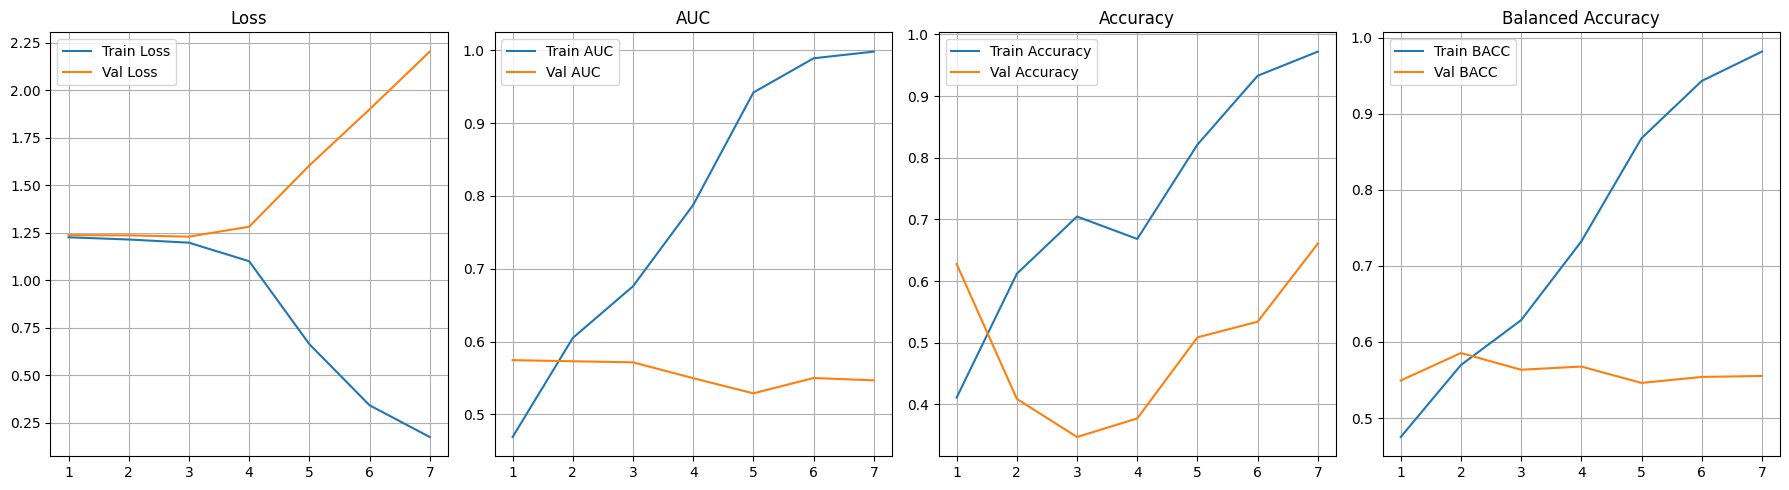


--- Final Test Evaluation ---
Evaluating test set with optimal threshold: 0.50


Test: 100%|██████████| 20/20 [00:01<00:00, 13.32it/s]


Test -> Loss: 1.2330 | AUC: 0.4935 | ACC: 0.6228 | BACC: 0.4912 | F1: 0.1560
Prediction Distribution: {np.int64(0): 417, np.int64(1): 214}

Final Test Metrics (Threshold = 0.50):
  -> Accuracy (ACC)         : 0.6228
  -> Balanced Accuracy (BACC): 0.4912
  -> AUC                    : 0.4935
  -> pAUC (FPR<=0.2)        : 0.0968
  -> F1-Score               : 0.1560


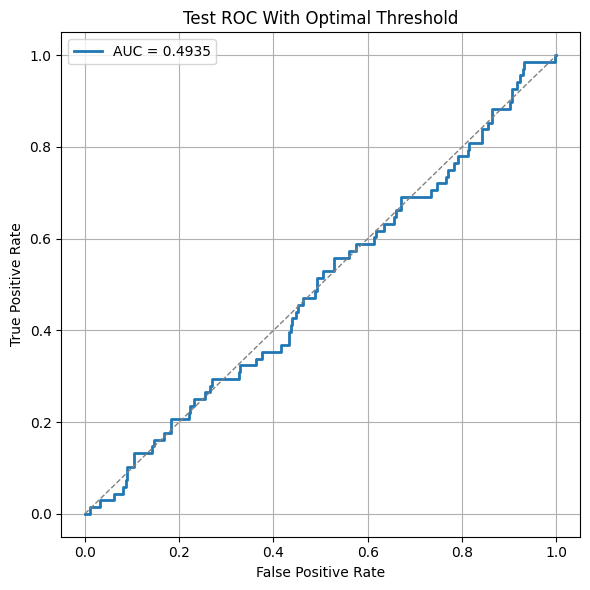

TP: 22 | TN: 371 | FP: 192 | FN: 46 | Precision: 0.1028 | Recall: 0.3235 | Specificity: 0.6590


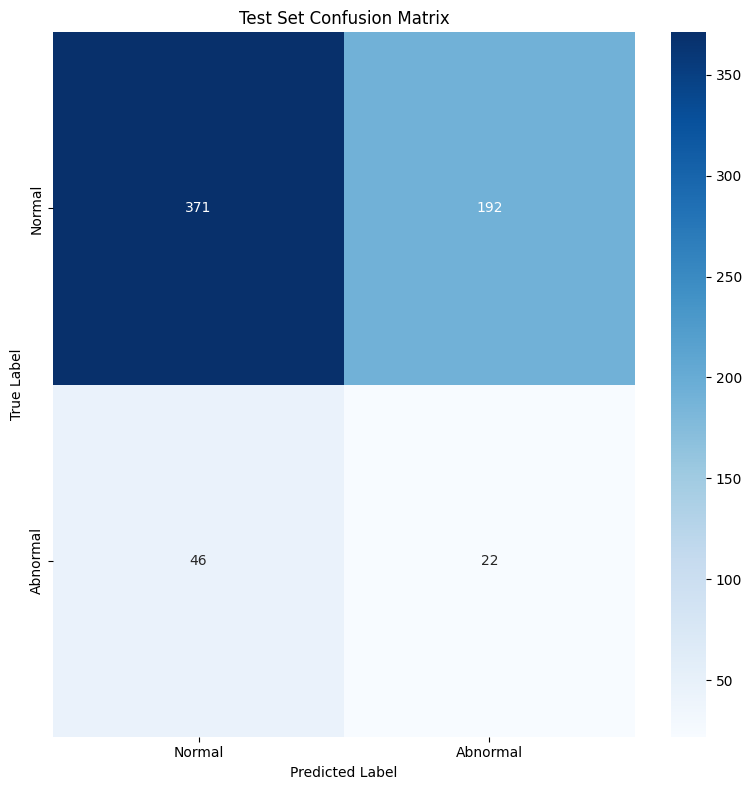

In [6]:
def main():
    # --- Configuration ---
    SEED = 42
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # --- Data Transformations ---
    train_transform = transforms.Compose([
        ZScoreNormalizeSpectrogram(),
        AugmentSpectrogram(time_mask_param=2, freq_mask_param=2) 
    ])
    val_test_transform = transforms.Compose([
        ZScoreNormalizeSpectrogram(),
    ])
    # --- Dataset Loading ---
    print("Loading datasets for CQT spectrograms...")
    # This assumes the SpectrogramDataset class from the previous answer is defined
    normal_dataset = SpectrogramDataset(data_dir=FEATURES_DIR, category='normal', spec_type='cqt', transform=train_transform)
    abnormal_dataset = SpectrogramDataset(data_dir=FEATURES_DIR, category='abnormal', spec_type='cqt', transform=train_transform)
    
    full_dataset = ConcatDataset([normal_dataset, abnormal_dataset])
    all_labels = [sample['label'] for sample in full_dataset] # type: ignore
    print(f"Total samples loaded: {len(full_dataset)}")

    # --- Stratified Data Splitting ---
    indices = list(range(len(full_dataset)))
    # Splitting indices: 70% train, 15% validation, 15% test
    train_idx, temp_idx, _, _ = train_test_split(indices, all_labels, test_size=0.3, stratify=all_labels, random_state=SEED)
    temp_labels = [all_labels[i] for i in temp_idx]
    val_idx, test_idx, _, _ = train_test_split(temp_idx, temp_labels, test_size=0.5, stratify=temp_labels, random_state=SEED)

    # Create dataset subsets with appropriate transforms
    full_dataset_no_aug = ConcatDataset([
        SpectrogramDataset(data_dir=FEATURES_DIR, category='normal', spec_type='cqt', transform=val_test_transform),
        SpectrogramDataset(data_dir=FEATURES_DIR, category='abnormal', spec_type='cqt', transform=val_test_transform)
    ])

    train_set = Subset(full_dataset, train_idx) # Uses augmentations
    val_set = Subset(full_dataset_no_aug, val_idx) # No augmentations
    test_set = Subset(full_dataset_no_aug, test_idx) # No augmentations

    print(f"Split Sizes => Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")
    print(f"Label Distribution (Train): {Counter([all_labels[i] for i in train_idx])}")
    print(f"Label Distribution (Validation): {Counter([all_labels[i] for i in val_idx])}")
    print(f"Label Distribution (Test): {Counter([all_labels[i] for i in test_idx])}")

    # --- Data Loaders ---
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)
    val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    print(f"Data split => Train: {len(train_set)}, Validation: {len(val_set)}, Test: {len(test_set)}")
    print(f"Label Distribution (Train): {Counter([all_labels[i] for i in train_idx])}")

    # --- Model, Criterion, and Optimizer Setup ---
    head = AnomalyScorer(in_dim=320, dropout=0.4, mode='classifier-1')
    model = CQTMobileViTClassifier(head=head).to(device)

    # Use weighted Binary Cross-Entropy loss for imbalanced data
    pos_count = sum(all_labels); neg_count = len(all_labels) - pos_count
    pos_weight = torch.tensor([neg_count / (pos_count + 1e-8)], dtype=torch.float32).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    print(f"\nUsing BCEWithLogitsLoss with pos_weight: {pos_weight.item():.2f}")

    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

    model_path = os.path.join(CHECKPOINT_DIR, "best_model.pth")
    os.makedirs(os.path.dirname(model_path), exist_ok=True)

    # --- Training ---
    print("\nStarting model training...")
    best_threshold = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=NUM_EPOCHS,
        model_save_path=model_path,
        device=device,
        save_plots=True,
        patience=PATIENCE
    )
    
    # --- Final Test Evaluation ---
    print("\n--- Final Test Evaluation ---")
    model.load_state_dict(torch.load(model_path, map_location=device))

    # Evaluate using the best threshold found during validation
    print(f"Evaluating test set with optimal threshold: {best_threshold:.2f}")
    
    # The simplified evaluate_model now returns the f1 score directly
    _, test_auc, test_acc, test_bacc, test_f1, all_labels_test, all_probs_test, _ = evaluate_model(
        model=model, data_loader=test_loader, criterion=criterion, phase="Test", device=device, threshold=best_threshold
    )
    
    # We must set the threshold for the test evaluation predictions.
    # The new evaluate_model does not take threshold as an argument, so we apply it manually for the final report.
    all_preds_test = (np.array(all_probs_test) > best_threshold).astype(int)
    final_acc = accuracy_score(all_labels_test, all_preds_test)
    final_bacc = balanced_accuracy_score(all_labels_test, all_preds_test)
    final_f1 = f1_score(all_labels_test, all_preds_test)
    final_pauc = calculate_pAUC(labels=all_labels_test, preds=all_probs_test, max_fpr=0.2)

    print(f"\nFinal Test Metrics (Threshold = {best_threshold:.2f}):")
    print(f"  -> Accuracy (ACC)         : {final_acc:.4f}")
    print(f"  -> Balanced Accuracy (BACC): {final_bacc:.4f}")
    print(f"  -> AUC                    : {test_auc:.4f}")
    print(f"  -> pAUC (FPR<=0.2)        : {final_pauc:.4f}")
    print(f"  -> F1-Score               : {final_f1:.4f}")

    # --- Plotting ---
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true=all_labels_test, y_score=all_probs_test)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, lw=2, label=f"AUC = {test_auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Test ROC With Optimal Threshold")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(CHECKPOINT_DIR, "roc_test_optimal.png"))
    plt.show()
    plt.close()

    class_labels = ["Normal", "Abnormal"]
    plot_confusion_matrix(y_true=all_labels_test, y_pred=all_preds_test, labels=class_labels, save_path=CHECKPOINT_DIR, title="Test Set Confusion Matrix")


if __name__ == "__main__":
    main()